In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torchvision

from dataloading.nvidia import NvidiaDataset, NvidiaSpringTrainDataset, NvidiaTrainDataset, NvidiaValidationDataset
from network import PilotNet
from metrics.metrics import calculate_closed_loop_metrics, calculate_lateral_errors, calculate_interventions

%load_ext autoreload 
%autoreload 2

In [3]:
def calculate_metrics(driving_ds, expert_ds):
    metrics_df = pd.DataFrame(columns=["model", "mae", "rmse", "max", "failure_rate", 
                                       "interventions", "whiteness", "expert_whiteness"])

    for name, ds in driving_ds.items():
        print(f"Calculating metrics for {name}")
        metrics = calculate_closed_loop_metrics(ds.frames, expert_ds.frames)
        metrics['model'] = name
        metrics_df = metrics_df.append(metrics, ignore_index=True)
        
    return metrics_df

In [74]:
def draw_error_plot_ax(ax, model_ds, expert_ds, title=None):
    lat_errors = calculate_lateral_errors(model_ds.frames[:-1000], expert_ds.frames, only_autonomous=True)
    positions_df = model_ds.frames[:-1000]
    
    autonomous_df = positions_df[positions_df.autonomous].reset_index(drop=True)
    ax.scatter(autonomous_df["position_x"], autonomous_df["position_y"],
               s=5,
               c=lat_errors, cmap=plt.cm.coolwarm)
    
    manual_df = positions_df[positions_df.autonomous == False].reset_index(drop=True)
    ax.scatter(manual_df["position_x"], manual_df["position_y"],
                s=5,
                c="#2BFA00")
    
    positions_df['autonomous_next'] = positions_df.shift(-1)['autonomous']
    interventions_df = positions_df[positions_df.autonomous & (positions_df.autonomous_next == False)]
    ax.scatter(interventions_df["position_x"], interventions_df["position_y"],
                s=150,
               marker='x',
                c="red")
    
    if title:
        ax.set_title(title)

In [14]:
def draw_error_plot(model_ds, expert_ds, title=None):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    draw_error_plot_ax(ax, model_ds, expert_ds, title)

In [6]:
root_path = Path("/media/romet/data2/datasets/rally-estonia/dataset")
expert_ds = NvidiaDataset([root_path / '2021-10-26-10-49-06_e2e_rec_ss20_elva'])
expert_back_ds = NvidiaDataset([root_path / '2021-10-26-11-08-59_e2e_rec_ss20_elva_back'])

/media/romet/data2/datasets/rally-estonia/dataset/2021-10-26-10-49-06_e2e_rec_ss20_elva: 33045
/media/romet/data2/datasets/rally-estonia/dataset/2021-10-26-11-08-59_e2e_rec_ss20_elva_back: 33281


In [55]:
autumn3_ds = NvidiaDataset([root_path / '2021-11-25-12-09-43_e2e_rec_elva-nvidia-v1-0.8'])
print(calculate_closed_loop_metrics(autumn3_ds.frames, expert_ds.frames))
draw_error_plot(autumn3_ds, expert_ds, "2021-11-25-12-09-43_e2e_rec_elva-nvidia-v1-0.8")

/media/romet/data2/datasets/rally-estonia/dataset/2021-11-25-12-09-43_e2e_rec_elva-nvidia-v1-0.8: 18799


KeyboardInterrupt: 

In [110]:
nvidia_1_backward = NvidiaDataset([root_path / '2021-11-25-12-09-43_e2e_rec_elva-nvidia-v1-0.8']).frames
backward_metrics = calculate_closed_loop_metrics(nvidia_1_backward, expert_ds.frames)
backward_metrics['interventions'] = backward_metrics['interventions'] - 1
backward_metrics

/media/romet/data2/datasets/rally-estonia/dataset/2021-11-25-12-09-43_e2e_rec_elva-nvidia-v1-0.8: 18799


{'mae': 0.37587870733922985,
 'rmse': 0.47928848727356366,
 'max': 1.7176898374676317,
 'failure_rate': 3.9274752756621574,
 'distance': 4264.134055328147,
 'distance_per_intervention': 609.162007904021,
 'interventions': 6,
 'whiteness': 38.88838217665873,
 'expert_whiteness': 22.53589576708035}

In [112]:
nvidia_1_forward = NvidiaDataset([root_path / '2021-11-25-12-21-17_e2e_rec_elva-nvidia-v1-0.8-forward']).frames[:-1000]
forward_metrics = calculate_closed_loop_metrics(nvidia_1_forward, expert_ds.frames)
forward_metrics['interventions'] = forward_metrics['interventions'] - 1
forward_metrics

/media/romet/data2/datasets/rally-estonia/dataset/2021-11-25-12-21-17_e2e_rec_elva-nvidia-v1-0.8-forward: 15942


{'mae': 0.47486192368170654,
 'rmse': 0.6125809225330732,
 'max': 1.7179960068256253,
 'failure_rate': 10.460220673635307,
 'distance': 3395.2976539533934,
 'distance_per_intervention': 424.41220674417417,
 'interventions': 7,
 'whiteness': 41.09282924795016,
 'expert_whiteness': 22.53589576708035}

In [117]:
nvidia_1 = pd.concat([nvidia_1_forward, nvidia_1_backward])
total_metrics = calculate_closed_loop_metrics(nvidia_1, expert_ds.frames)
total_metrics['distance'] = forward_metrics['distance'] + backward_metrics['distance']
total_metrics['interventions'] = forward_metrics['interventions'] + backward_metrics['interventions']
total_metrics['distance_per_intervention'] = total_metrics['distance'] / total_metrics['interventions']
total_metrics

{'mae': 0.41921888814384234,
 'rmse': 0.5417026821631205,
 'max': 1.7179960068256253,
 'failure_rate': 6.796302199553714,
 'distance': 7659.43170928154,
 'distance_per_intervention': 589.1870545601184,
 'interventions': 13,
 'whiteness': 41.51488223275638,
 'expert_whiteness': 22.53589576708035}

In [116]:
print(total_metrics)

{'mae': 0.41921888814384234, 'rmse': 0.5417026821631205, 'max': 1.7179960068256253, 'failure_rate': 6.796302199553714, 'distance': 7659.43170928154, 'distance_per_intervention': 589.1870545601184, 'interventions': 13, 'whiteness': 41.51488223275638, 'expert_whiteness': 22.53589576708035}


In [62]:
x1 = frames['position_x']
y1 = frames['position_y']
x2 = frames.shift(-1)['position_x']
y2 = frames.shift(-1)['position_y']
frames['distance'] = np.sqrt((x2-x1)**2 + (y2-y1)**2)
frames[['position_x', 'position_y', 'distance']]

,position_x,position_y,distance
0,-7387.915526,-3808.599668,0.223513
1,-7387.891618,-3808.377437,0.226773
2,-7387.867132,-3808.151990,0.224695
3,-7387.842385,-3807.928662,0.228995
4,-7387.817053,-3807.701072,0.229083
...,...,...,...
15937,-8961.915108,-1362.161502,0.000000
15938,-8961.915108,-1362.161502,0.000000
15939,-8961.915108,-1362.161502,0.000000
15940,-8961.915108,-1362.161502,0.000000


/media/romet/data2/datasets/rally-estonia/dataset/2021-11-25-12-37-01_e2e_rec_elva-lidar-v1-0.8-back: 5734
{'mae': 0.8151227895180789, 'rmse': 0.8798224850358789, 'max': 1.567584810708111, 'failure_rate': 35.17344274524431, 'distance': 1376.9478616074941, 'distance_per_intervention': 688.4739308037471, 'interventions': 2, 'whiteness': 32.10900189063189, 'expert_whiteness': 22.53589576708035}


/tmp/ipykernel_3763113/2245734033.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positions_df['autonomous_next'] = positions_df.shift(-1)['autonomous']


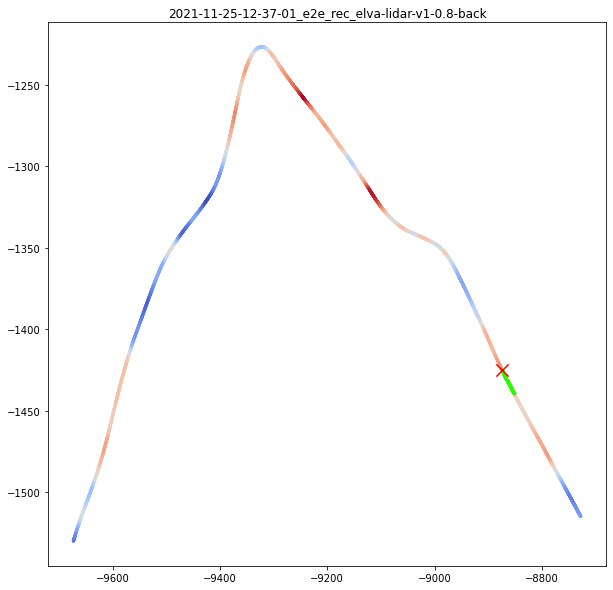

In [108]:
autumn3_ds = NvidiaDataset([root_path / '2021-11-25-12-37-01_e2e_rec_elva-lidar-v1-0.8-back'])
print(calculate_closed_loop_metrics(autumn3_ds.frames, expert_ds.frames))
draw_error_plot(autumn3_ds, expert_ds, "2021-11-25-12-37-01_e2e_rec_elva-lidar-v1-0.8-back")

/media/romet/data2/datasets/rally-estonia/dataset/2021-11-25-12-45-35_e2e_rec_elva-lidar-v1-0.8-back: 18522
{'mae': 0.5667377311645897, 'rmse': 0.6959409928953714, 'max': 1.7169571196118079, 'failure_rate': 16.15131762215165, 'distance': 4282.320763126687, 'distance_per_intervention': 1427.4402543755623, 'interventions': 3, 'whiteness': 33.28783963749647, 'expert_whiteness': 22.53589576708035}


/tmp/ipykernel_3763113/2245734033.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positions_df['autonomous_next'] = positions_df.shift(-1)['autonomous']


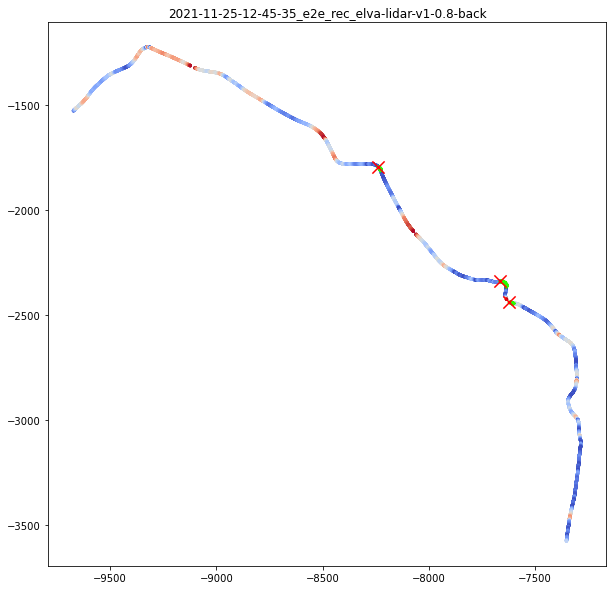

In [107]:
autumn3_ds = NvidiaDataset([root_path / '2021-11-25-12-45-35_e2e_rec_elva-lidar-v1-0.8-back'])
print(calculate_closed_loop_metrics(autumn3_ds.frames, expert_ds.frames))
draw_error_plot(autumn3_ds, expert_ds, "2021-11-25-12-45-35_e2e_rec_elva-lidar-v1-0.8-back")

In [12]:
frames = autumn3_ds.frames
frames['autonomous_next'] = frames.shift(-1)['autonomous']
interventions = frames[frames.autonomous & (frames.autonomous_next == False)]

/media/romet/data2/datasets/rally-estonia/dataset/2021-11-25-12-21-17_e2e_rec_elva-nvidia-v1-0.8-forward: 15942
{'mae': 0.4692954907949449, 'rmse': 0.6069038613636565, 'max': 1.7179960068256253, 'failure_rate': 10.241648898365316, 'distance': 3426.489026627739, 'distance_per_intervention': 92.60781153047942, 'interventions': 37, 'whiteness': 40.25641644651432, 'expert_whiteness': 22.53589576708035}


/tmp/ipykernel_3763113/2245734033.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positions_df['autonomous_next'] = positions_df.shift(-1)['autonomous']


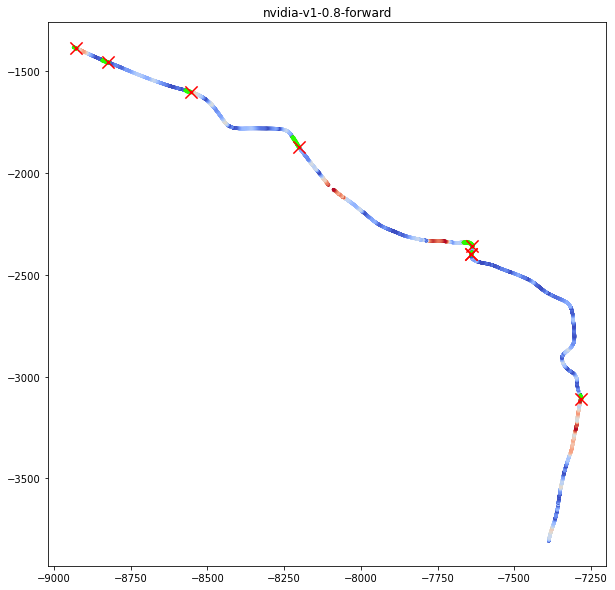

In [76]:
autumn3_ds = NvidiaDataset([root_path / '2021-11-25-12-21-17_e2e_rec_elva-nvidia-v1-0.8-forward'])
print(calculate_closed_loop_metrics(autumn3_ds.frames, expert_ds.frames))
draw_error_plot(autumn3_ds, expert_ds, "nvidia-v1-0.8-forward")

In [10]:
datasets = {
        'autumn-v3': NvidiaDataset([root_path / '2021-11-03-12-35-19_e2e_rec_elva_autumn-v3']),
        'wide-v2': NvidiaDataset([root_path / '2021-11-03-13-13-16_e2e_rec_elva_wide-v2']),
        'autumn-v1': NvidiaDataset([root_path / '2021-11-03-13-51-53_e2e_rec_elva_autumn-v1', 
                                root_path / '2021-11-03-14-02-07_e2e_rec_elva_autumn-v1_continue']),
        'autumn-v3-overfit': NvidiaDataset([root_path / '2021-11-03-14-31-14_e2e_rec_elva_autumn-v3-last']),
        'autumn-v3-drive-2': NvidiaDataset([root_path / '2021-11-03-15-07-12_e2e_rec_elva_autumn-v3-drive2'])
}

/media/romet/data2/datasets/rally-estonia/dataset/2021-11-03-12-35-19_e2e_rec_elva_autumn-v3: 30068
/media/romet/data2/datasets/rally-estonia/dataset/2021-11-03-13-13-16_e2e_rec_elva_wide-v2: 29327
/media/romet/data2/datasets/rally-estonia/dataset/2021-11-03-13-51-53_e2e_rec_elva_autumn-v1: 15142
/media/romet/data2/datasets/rally-estonia/dataset/2021-11-03-14-02-07_e2e_rec_elva_autumn-v1_continue: 15153
/media/romet/data2/datasets/rally-estonia/dataset/2021-11-03-14-31-14_e2e_rec_elva_autumn-v3-last: 29630
/media/romet/data2/datasets/rally-estonia/dataset/2021-11-03-15-07-12_e2e_rec_elva_autumn-v3-drive2: 29729


In [15]:
metrics = calculate_metrics(datasets, expert_ds)
metrics

Calculating metrics for autumn-v3
Calculating metrics for wide-v2
Calculating metrics for autumn-v1
Calculating metrics for autumn-v3-overfit
Calculating metrics for autumn-v3-drive-2


,model,mae,rmse,max,failure_rate,interventions,whiteness,expert_whiteness
0,autumn-v3,0.502230,0.622957,1.714611,12.241000,19,40.575212,22.535896
1,wide-v2,0.443960,0.588631,1.726209,11.112764,19,31.612728,22.535896
2,autumn-v1,0.552140,0.684312,1.719333,17.456469,39,27.345045,22.535896
3,autumn-v3-overfit,0.451016,0.586969,1.717028,10.650157,30,35.151487,22.535896
4,autumn-v3-drive-2,0.450061,0.562311,1.721292,7.595274,31,37.789747,22.535896


In [ ]:
# intervention_adjustments = {
#     'autumn-v3': 0, 
#     'wide-v2': 0,
#     'autumn-v1': 0,
#     'autumn-v3-overfit': 0,
#     'autumn-v3-drive-2': 0,
# }

# for name, adj in intervention_adjustments.items():
#     metrics[metrics.model == name] = metrics[metrics.model == name].interventions - adj

In [16]:
datasets_backwards = {
    'autumn-v3': NvidiaDataset([root_path / '2021-11-03-12-53-38_e2e_rec_elva_back_autumn-v3']),
    'wide-v2': NvidiaDataset([root_path / '2021-11-03-13-30-48_e2e_rec_elva_back_wide-v2']),
    'autumn-v1': NvidiaDataset([root_path / '2021-11-03-14-12-10_e2e_rec_elva_back_autumn-v1']),
    'autumn-v3-overfit': NvidiaDataset([root_path / '2021-11-03-14-48-21_e2e_rec_elva_back_autumn-v3-last']),
    'autumn-v3-drive-2': NvidiaDataset([root_path / '2021-11-03-15-25-36_e2e_rec_elva_back_autumn-v3-drive2'])
}

/media/romet/data2/datasets/rally-estonia/dataset/2021-11-03-12-53-38_e2e_rec_elva_back_autumn-v3: 30471
/media/romet/data2/datasets/rally-estonia/dataset/2021-11-03-13-30-48_e2e_rec_elva_back_wide-v2: 30505
/media/romet/data2/datasets/rally-estonia/dataset/2021-11-03-14-12-10_e2e_rec_elva_back_autumn-v1: 30376
/media/romet/data2/datasets/rally-estonia/dataset/2021-11-03-14-48-21_e2e_rec_elva_back_autumn-v3-last: 30747
/media/romet/data2/datasets/rally-estonia/dataset/2021-11-03-15-25-36_e2e_rec_elva_back_autumn-v3-drive2: 30382


In [17]:
metrics_backwards = calculate_metrics(datasets_backwards, expert_back_ds)
metrics_backwards

Calculating metrics for autumn-v3
Calculating metrics for wide-v2
Calculating metrics for autumn-v1
Calculating metrics for autumn-v3-overfit
Calculating metrics for autumn-v3-drive-2


,model,mae,rmse,max,failure_rate,interventions,whiteness,expert_whiteness
0,autumn-v3,0.516410,0.650548,1.721210,11.159653,13,27.871334,24.159325
1,wide-v2,0.476433,0.619278,1.719881,10.728426,13,29.357156,24.159325
2,autumn-v1,0.551390,0.677234,1.718249,12.491294,11,26.772094,24.159325
3,autumn-v3-overfit,0.500938,0.620764,1.715706,11.452504,23,34.136939,24.159325
4,autumn-v3-drive-2,0.444941,0.556454,1.720779,7.264722,23,32.510528,24.159325


0 autumn-v3
1 wide-v2
2 autumn-v1
3 autumn-v3-overfit
4 autumn-v3-drive-2
0 autumn-v3
1 wide-v2
2 autumn-v1
3 autumn-v3-overfit
4 autumn-v3-drive-2


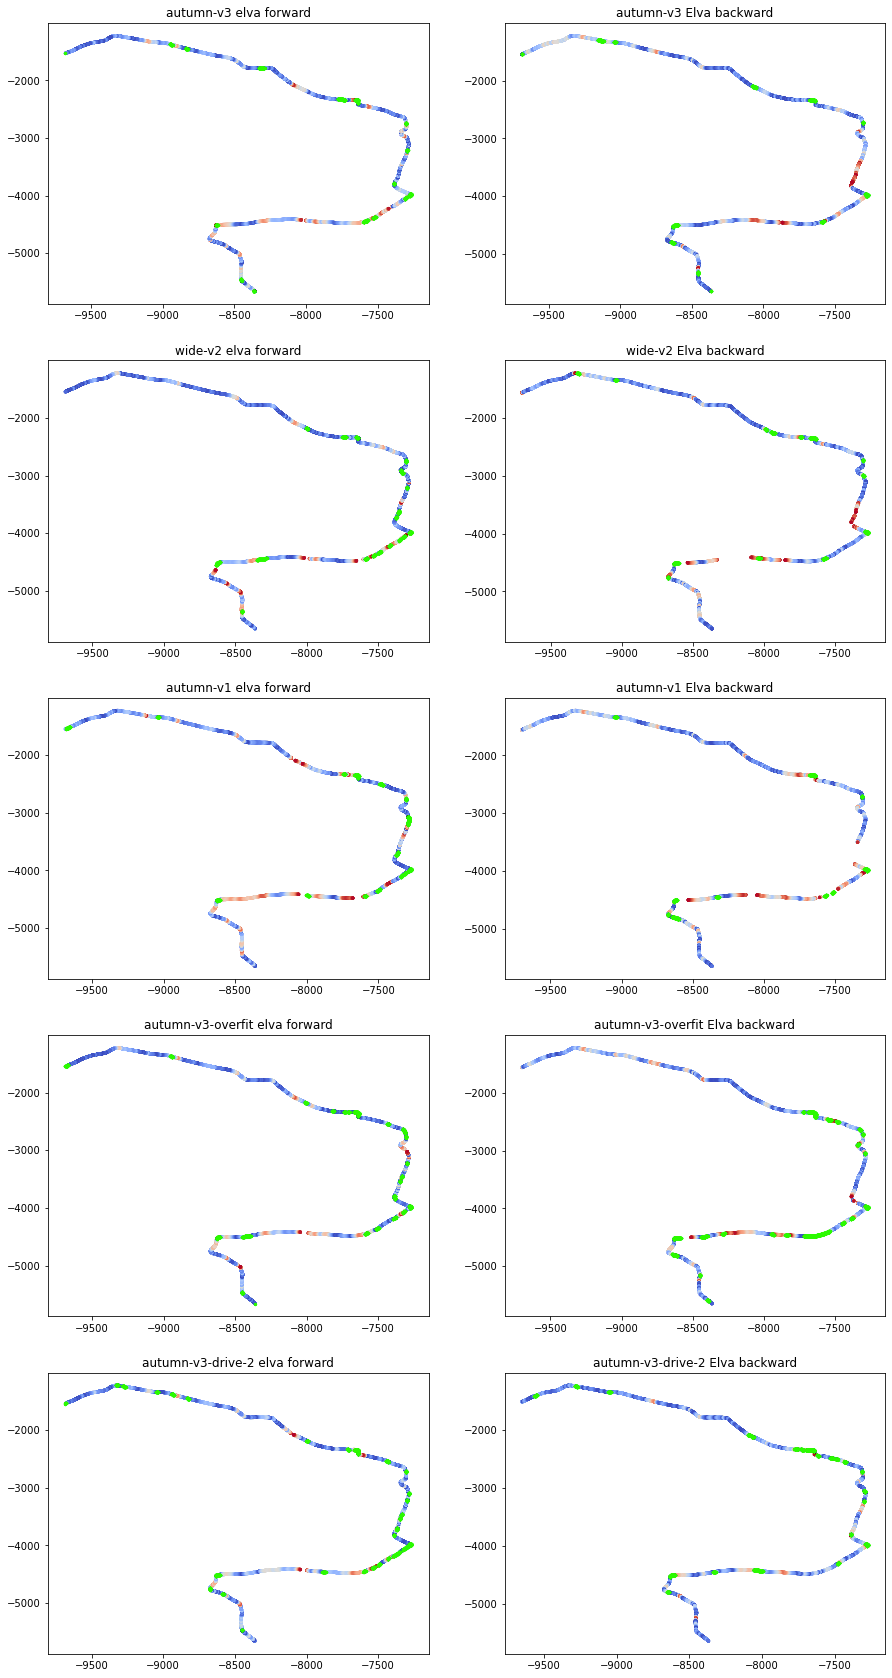

In [19]:
fig, ax = plt.subplots(5, 2, figsize=(15, 30))

for i, (name, ds) in enumerate(datasets.items()): 
    print(i, name)
    draw_error_plot_ax(ax[i][0], ds, expert_ds, f"{name} elva forward")
    
for i, (name, ds) in enumerate(datasets_backwards.items()): 
    print(i, name)
    draw_error_plot_ax(ax[i][1], ds, expert_back_ds, f"{name} Elva backward")

In [20]:
fig.savefig("elva-2021-11-03.png", facecolor="white")